In [ ]:
# # # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
month = "joined"
# file_path = "/content/drive/My Drive/filtered_pred_"+month+"2024.csv"
# file_path = "/content/drive/MyDrive/filtered_pred_"+month+"2024.csv"
file_path = "data/filtered_pred_"+month+"2024.csv"

In [14]:
# Import necessary libraries
from pyspark.sql import SparkSession

# Stop any existing Spark session
# Step 1: Initialize a Spark session
spark = SparkSession.builder \
    .appName("BigDataProcessing") \
    .config("spark.executor.memory", "5g") \
    .config("spark.driver.memory", "5g") \
    .getOrCreate()
# Step 2: Load your CSV file into a Spark DataFrame
data = spark.read.csv(file_path, header=True, inferSchema=True)

In [9]:
holidays = ['2024-01-01', '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-17', '2024-01-25', '2024-01-26', '2024-02-14', '2024-02-19', '2024-02-24', '2024-03-06', '2024-03-08', '2024-03-12', '2024-03-24', '2024-03-25', '2024-03-25', '2024-03-29', '2024-03-31', '2024-04-05', '2024-04-09', '2024-04-09', '2024-04-09', '2024-04-11', '2024-04-13', '2024-04-14', '2024-04-14', '2024-04-17', '2024-04-21', '2024-05-08', '2024-05-23', '2024-06-17', '2024-07-07', '2024-07-17', '2024-08-15', '2024-08-15', '2024-08-19', '2024-08-26', '2024-08-26', '2024-09-07', '2024-09-15', '2024-09-16', '2024-10-02', '2024-10-03', '2024-10-09', '2024-10-10', '2024-10-11', '2024-10-11', '2024-10-12', '2024-10-17', '2024-10-20', '2024-10-31', '2024-10-31', '2024-11-02', '2024-11-03', '2024-11-07', '2024-11-15', '2024-11-24', '2024-12-24','2024-12-25']

In [21]:
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql import functions as F

# Ensure DATE_HOUR column is created before dropping DATE and HOUR columns
data = data.withColumn("HOUR", F.lpad(F.col("HOUR").cast("string"), 2, "0"))
data = data.withColumn("DATE_HOUR", F.concat_ws(" ", F.col("DATE"), F.col("HOUR")))

data_grouped = data.groupBy("DATE_HOUR").agg(
    spark_sum("NO_OF_ADULT").alias("NO_OF_ADULT"),
    spark_sum("NO_OF_CHILD").alias("NO_OF_CHILD")
)

data_grouped = data_grouped.orderBy("DATE_HOUR")
data_grouped = data_grouped.withColumn("TOTAL_PASSENGERS", F.col("NO_OF_ADULT") + F.col("NO_OF_CHILD"))
data_grouped = data_grouped.drop("NO_OF_ADULT", "NO_OF_CHILD")
data_grouped = data_grouped.withColumn("DAY_OF_WEEK", F.dayofweek(F.col("DATE_HOUR").substr(1, 10)))
data_grouped = data_grouped.withColumn("IS_WEEKEND", F.when(data_grouped.DAY_OF_WEEK.isin([1, 7]), 1).otherwise(0))
data_grouped = data_grouped.withColumn("IS_HOLIDAY", F.when(F.col("DATE_HOUR").substr(1, 10).isin(holidays), 1).otherwise(0))
data_grouped = data_grouped.drop("ROUTE_NAME")
data_grouped.show(10)

+-------------+----------------+-----------+----------+----------+
|    DATE_HOUR|TOTAL_PASSENGERS|DAY_OF_WEEK|IS_WEEKEND|IS_HOLIDAY|
+-------------+----------------+-----------+----------+----------+
|2024-05-20 09|               1|          2|         0|         0|
|2024-05-31 01|             242|          6|         0|         0|
|2024-05-31 02|             531|          6|         0|         0|
|2024-05-31 03|             827|          6|         0|         0|
|2024-05-31 04|             671|          6|         0|         0|
|2024-05-31 05|             489|          6|         0|         0|
|2024-05-31 06|             526|          6|         0|         0|
|2024-05-31 07|             442|          6|         0|         0|
|2024-05-31 08|             779|          6|         0|         0|
|2024-05-31 09|             954|          6|         0|         0|
+-------------+----------------+-----------+----------+----------+
only showing top 10 rows



In [22]:
# Step 7: Convert 'DATE_HOUR' to datetime format, then set as the index
import pandas as pd
df = data_grouped.toPandas()
df['DATE_HOUR'] = pd.to_datetime(df['DATE_HOUR'], format='%Y-%m-%d %H')
df.set_index('DATE_HOUR', inplace=True)
df.sort_index(inplace=True)

print(df)



                     TOTAL_PASSENGERS  DAY_OF_WEEK  IS_WEEKEND  IS_HOLIDAY
DATE_HOUR                                                                 
2024-05-20 09:00:00                 1            2           0           0
2024-05-31 01:00:00               242            6           0           0
2024-05-31 02:00:00               531            6           0           0
2024-05-31 03:00:00               827            6           0           0
2024-05-31 04:00:00               671            6           0           0
...                               ...          ...         ...         ...
2024-10-22 04:00:00              4094            3           0           0
2024-10-22 05:00:00              2994            3           0           0
2024-10-22 06:00:00              2036            3           0           0
2024-10-22 07:00:00               806            3           0           0
2024-10-22 08:00:00                31            3           0           0

[2133 rows x 4 columns]


In [23]:
# Step 7: Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(df)
print(scaled_data)

split_ratio = 0.9
split_index = int(len(scaled_data) * split_ratio)
# Create Train and Test datasets
Train = scaled_data[:split_index]
Test = scaled_data[split_index:]



[[1.46066431e-05 1.66666667e-01 0.00000000e+00 0.00000000e+00]
 [3.53480763e-03 8.33333333e-01 0.00000000e+00 0.00000000e+00]
 [7.75612749e-03 8.33333333e-01 0.00000000e+00 0.00000000e+00]
 ...
 [2.97391254e-02 3.33333333e-01 0.00000000e+00 0.00000000e+00]
 [1.17729543e-02 3.33333333e-01 0.00000000e+00 0.00000000e+00]
 [4.52805936e-04 3.33333333e-01 0.00000000e+00 0.00000000e+00]]


In [24]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_input = 24
n_features = scaled_data.shape[1]
# It generates small batches of data in the format needed for time series models.
generator = TimeseriesGenerator(Train, Train, length = n_input, batch_size = 1)


2025-01-22 20:08:43.999183: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-22 20:08:44.025058: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-22 20:08:44.192874: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-22 20:08:44.633054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737556724.865342    2849 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737556724.92

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from keras.callbacks import EarlyStopping

# Define the LSTM model
model = Sequential([
    Bidirectional(LSTM(units=100, activation='tanh', return_sequences=True), input_shape=(n_input, n_features)),
    Bidirectional(LSTM(units=50, activation='tanh')),
    Dense(units=n_features, activation='linear')  # 'linear' is appropriate for regression
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

epochs = 30

# Add EarlyStopping callback to stop training if the validation loss does not improve
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model with the EarlyStopping callback
history = model.fit(generator, epochs=epochs, verbose=1, callbacks=[early_stopping])

/home/jeev/.local/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1451/1895 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0380 - mae: 0.1258

In [27]:
# from tensorflow.keras.models import load_model
# model = load_model('/content/drive/My Drive/full_models/'+month+'.keras')
# Step 14: Generate sequences for the test data
test_generator = TimeseriesGenerator(Test, Test, length=n_input, batch_size=1)

# Step 15: Make predictions
predictions = model.predict(test_generator)

# Step 16: Inverse transform the predictions and actual test data
predicted_values = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(Test[n_input:])  # Use Test[n_input:] for matching lengths

/home/jeev/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


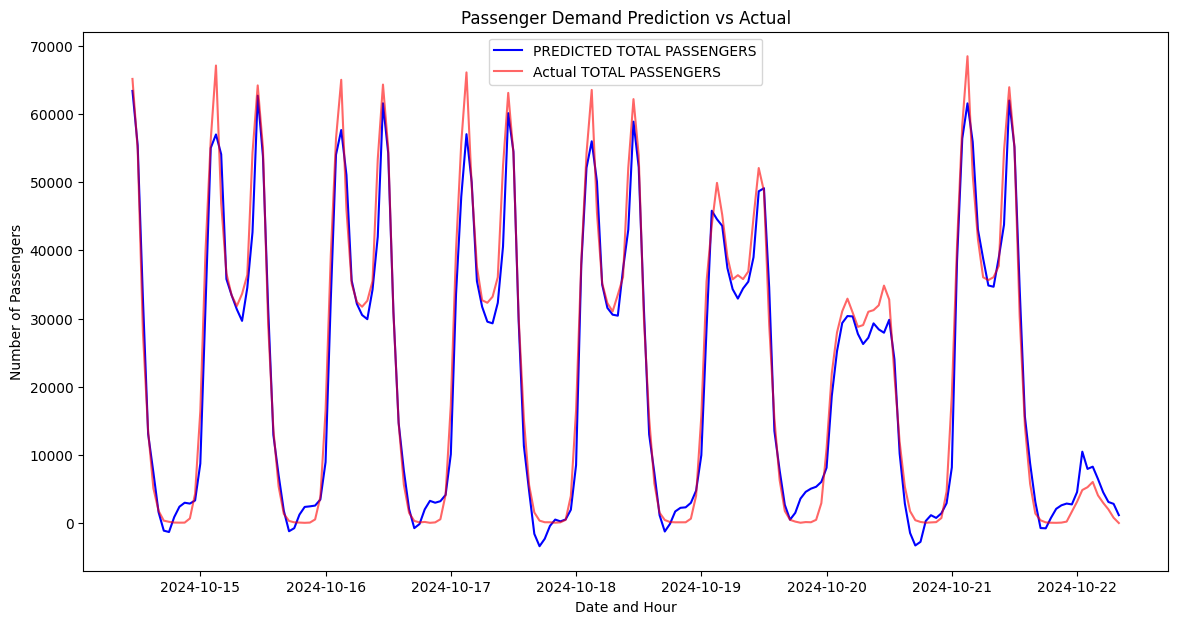

In [28]:

import matplotlib.pyplot as plt
import pandas as pd
# Step 17: Create a time index for the predicted values
time_index = pd.date_range(start=df.index[split_index + n_input], periods=len(predicted_values), freq='H')

# Step 18: Create a DataFrame for the predicted and actual values for better visualization
results = pd.DataFrame({
    'PREDICTED_TOTAL_PASSENGERS': predicted_values[:,0],
    'ACTUAL_TOTAL_PASSENGERS': actual_values[:,0],
}, index=time_index)

# Step 19: Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['PREDICTED_TOTAL_PASSENGERS'], label='PREDICTED TOTAL PASSENGERS', color='blue')
plt.plot(results.index, results['ACTUAL_TOTAL_PASSENGERS'], label='Actual TOTAL PASSENGERS', color='red', alpha=0.6)
plt.title('Passenger Demand Prediction vs Actual')
plt.xlabel('Date and Hour')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()



In [31]:
model.save(str(epochs)+month+'3_features.keras')